<h2>RNN ile Havayolu Yolcu Sayısı Tahmini

1) İş Problemi (Business Problem)
2) Veriyi Anlamak (Data Understanding)
3) Veriyi Hazırlamak (Data Preparation)
4) Modelleme (Modeling)
5) DeğerIendirme (Evaluation)

<hr>

<h3>1.) İş Problemi</h3>

<hr>

<h3>2.) Veriyi Anlamak</h3>

<h4>2.1.) Gerekli Kütüphanelerin Yüklenmesi

In [7]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras. layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os. environ ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf. compat.v1. logging.set_verbosity(tf.compat.v1.logging.ERROR)

<h4>2.2.) Veri Setinin Yüklenmesi ve Verinin İncelenmesi 

In [9]:
df = pd.read_csv('international-airline-passengers.csv')

In [10]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [11]:
df.columns = ['Month', 'Passengers']

In [12]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [13]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


Son satırı veriyi hazırlama bölümünde kaldıracağız.

In [15]:
df.shape

(145, 2)

In [16]:
df.dtypes

Month          object
Passengers    float64
dtype: object

Tarih değişkeninin type'ı object olduğu için yine bunu da düzenleyeceğiz.

In [18]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


Ortalamanın 280 olduğu bir veride standart sapma 119 olması, bu verideki değişkenliğin (yayılımın) fazla olduğunu göstermektedir. <br>
Ortalama ile medyan arasında çok bir fark olmadığı için çarpık bir yapı yok diyebiliriz.

<hr>

<h3>3.) Veriyi Hazırlamak</h3>

<b>3.1.) Veri Ön İşleme

In [24]:
df = df[:144]

In [25]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [26]:
df['Month'] = pd.to_datetime(df['Month'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [28]:
print('Minimum Tarih: ',df['Month'].min())
print('Maximum Tarih: ',df['Month'].max())

Minimum Tarih:  1949-01-01 00:00:00
Maximum Tarih:  1960-12-01 00:00:00


In [29]:
df.index = df['Month']

In [30]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [31]:
df.drop('Month', axis = 1, inplace = True)

In [32]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [33]:
result_df = df.copy()

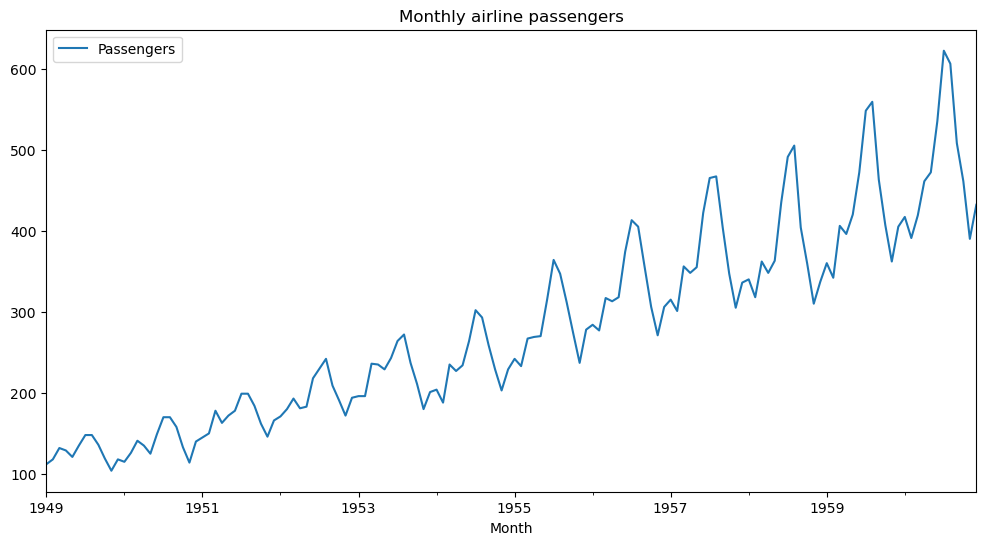

In [34]:
df.plot(figsize = (12,6), title = 'Monthly airline passengers');

Verimiz pandas DataFrame formundadır. Modelleme işlem için bunu numpy array'ine çevirelim

In [36]:
data = df['Passengers'].values

In [37]:
type(data)

numpy.ndarray

In [38]:
data[0].dtype

dtype('float64')

In [39]:
data = data.astype('float32')

In [40]:
data[0].dtype

dtype('float32')

In [41]:
data.shape

(144,)

Veriyi modellemeden önce bir boyut ayarlaması yapılması gerekmektedir

In [43]:
data = data.reshape(-1, 1)
# -1 -> 144
# 1 -> 1 (istenilen sütun sayısı)

In [44]:
data.shape

(144, 1)

<b>3.2.) Train - Test split

Time series problemlerinde, scikit-learn'deki train_test_split kullanılmaz. Bu yöntem rastgele böldüğü için zamana bağlı olan verimizi yanlış bölecektir. Zaman serilerinde biz bu işlemi kendimiz yapmalıyız.

In [47]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [48]:
train, test, position = split_data(data, 0.33)

In [49]:
print(train.shape, test.shape)

(96, 1) (48, 1)


<b>3.3.) Normalizasyon

Değişkenlere scale uygulamak, modelin performansını ve çalışma hızını arttıracaktır. 

In [52]:
scaler_train = MinMaxScaler(feature_range = (0, 1))

In [53]:
train = scaler_train.fit_transform(train)

In [54]:
scaler_test = MinMaxScaler(feature_range = (0, 1))

In [55]:
test = scaler_test.fit_transform(test)

In [56]:
train[0:3], test[0:3]

(array([[0.02588999],
        [0.04530746],
        [0.09061491]], dtype=float32),
 array([[0.04361373],
        [0.        ],
        [0.17133951]], dtype=float32))

<b>3.4.) Veri Setine Yeni Değişken Ekleme

Zaman serilerinde, serinin t anındaki değeri, en fazla kendisinden bir önceki zaman periyodundan etkilenir. <br>
Günlük periyoda sahip bir veri setinde, bir gün öncekine göre yorum yapılır.<br>
Haftalık periyoda sahip bir veri setinde, bir hafta öncekine göre yorum yapılır.<br>
Aylık periyoda sahip bir veri setinde, bir ay öncekine göre yorum yapılır.<br>

Bu yüzden bir önceki ayın değerlerini bir feature olarak modele koymaya çalışalım.

In [60]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i,0])

    return np.array(X), np.array(Y)

In [61]:
lookback = 1

In [62]:
# Train veri seti
X_train, y_train = create_features(train, lookback)

In [63]:
# Test veri seti
X_test, y_test = create_features(test, lookback)

In [64]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [65]:
# RNN, kendisine gelecek verinin 3 boyutlu bir yapıda olmasını ister.
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [66]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


<hr>

<h3>4.) Modelleme</h3>

In [69]:
# Sıralı katmanlardan oluşan bir sinir ağı oluşturmamızı sağlar.
model = Sequential()

# Units, nöronları ifade eder.
model.add(SimpleRNN(units = 50,
                    activation = 'relu',
                    input_shape = (X_train.shape[1],lookback)))

# Aşırı öğrenmeyi önlemek için eklenir.
model.add(Dropout(0.2))

# Çıkış katmanı
model.add(Dense(1))
# Çıkış katmanında tek bir tahmin değeri olacağı için 1 nöron olmalıdır.

In [70]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

Çıkış değeri sayısal bir değer olduğu için buna uygun loss metrikleri kullanılmalıdır.

In [73]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min")]

In [74]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0371
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0353 - val_loss: 0.0259
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 - val_loss: 0.0233
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.0141 - val_loss: 0.0239
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0122 - val_loss: 0.0223
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0096 - val_loss: 0.0213
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0064 - val_loss: 0.0212
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0067 - val_loss: 0.0207
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0051 - val_loss: 0.0207
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0039 - val_loss: 0.0208
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - val_loss: 0.0207
Epoch 11: early stopping


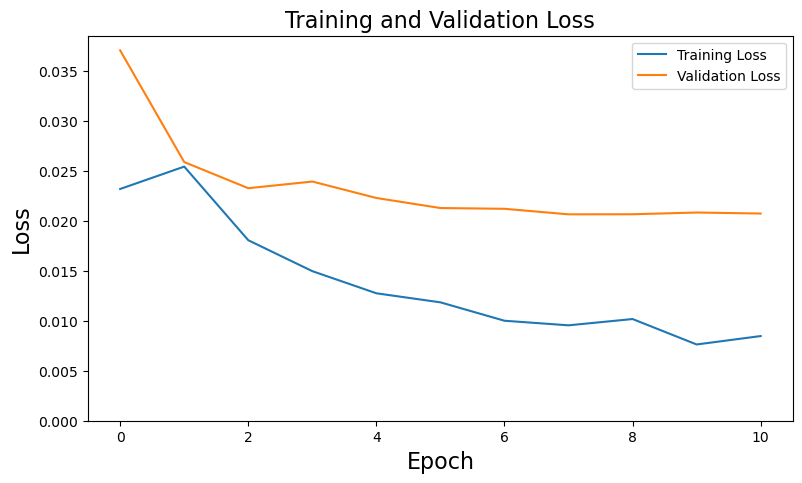

In [75]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()


<h3>5.) Değerlendirme</h3>

In [76]:
loss = model.evaluate(X_test, y_test, batch_size = 1)
print("\nTest Loss : %.1f%%" % (100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.0164

Test Loss : 2.1%


In [77]:
train_predict = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [78]:
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [79]:
# Scale işlemini geri alarak değerleri kontrol edelim.
train_predict = scaler_train.inverse_transform(train_predict) 
test_predict = scaler_test.inverse_transform(test_predict) 

In [80]:
y_train = scaler_train.inverse_transform(y_train) 
y_test = scaler_test.inverse_transform(y_test) 

In [81]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [82]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [145]:
print(f"Eğitim RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Eğitim RMSE: 23.90079116821289
Test RMSE: 46.22073745727539


Tahmin yapmak istediğimizde, 46 birimlik bir sapma payı vardır.

In [163]:
train_prediction_df = result_df[lookback:position]

In [165]:
train_prediction_df.head()

,Passengers
Month,
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0


In [167]:
train_prediction_df['Predicted'] = train_predict

In [169]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,134.131577
1949-03-01,132.0,137.773087
1949-04-01,129.0,148.136536
1949-05-01,121.0,145.907455
1949-06-01,135.0,139.963242


In [171]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,335.736084
1957-03-01,356.0,328.569061
1957-04-01,348.0,369.914856
1957-05-01,355.0,362.790955
1957-06-01,422.0,369.024384


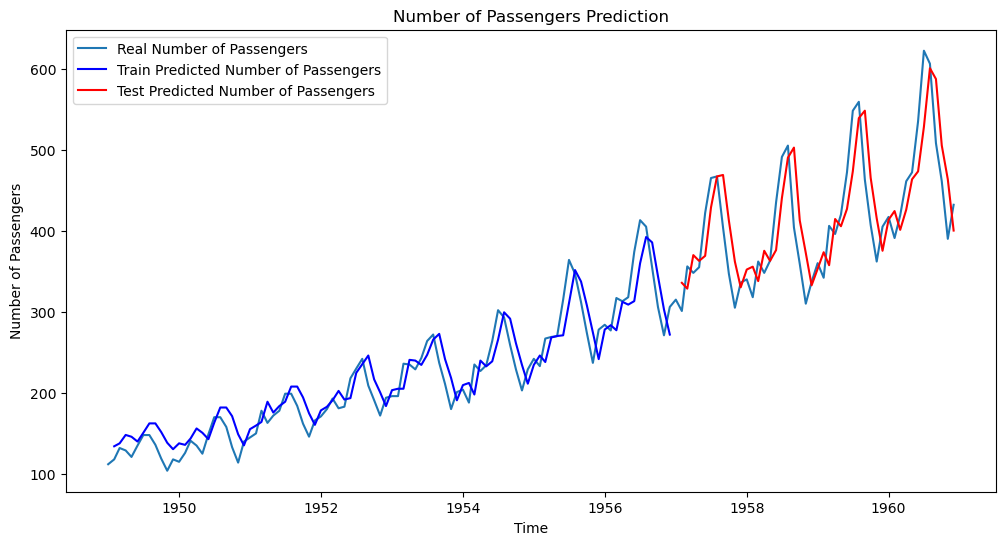

In [177]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(12,6))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = 'Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color = 'red', label = 'Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()